In [2]:
%load_ext autoreload
%autoreload 1
%aimport utilsLoaders


In [3]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
# import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
# gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
# datadir = gdrive / 'My Drive/NMBL Lab/opencap_nmd/data/2023-05_dhd'
datadir = Path('./datadir')

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'

def get_sto_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Dynamics/{trial}_shoulder.sto'

def get_model_path(sid):
    model_dir = datadir / f'opencap_data/{sid}/OpenSimData/Model/'
    return list(mdir.glob('*.osim'))[0]

    

In [4]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [5]:
df_session = pd.read_excel(datadir / 'session_info.xlsx')
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')


/Users/psr/opt/anaconda3/envs/opensim/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


p095


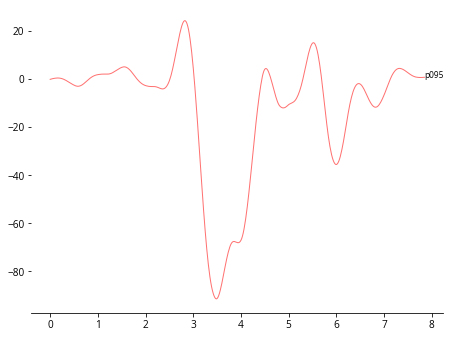

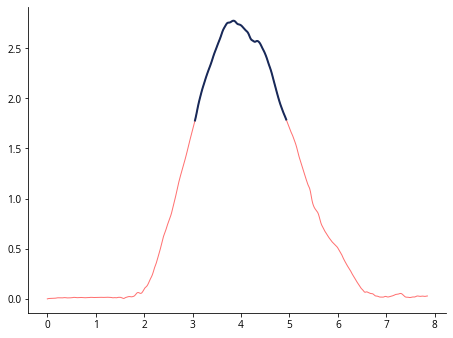

2631.648047450761


In [6]:
from numpy.linalg import norm

pid = 'p095'
trial_clean = 'tug_line'

df_temp = df_trial[df_trial.trial_clean == trial_clean]
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

rh = xyz[:,np.argmax(markers=='RHJC_study'),:]
lh = xyz[:,np.argmax(markers=='LHJC_study'),:]

rhlh = rh-lh
h = np.arctan2(rhlh[:,0], rhlh[:,2]) * 180 / np.pi
h = np.unwrap(h)
# h -= h[0]

avel = np.diff(h, prepend=h[0]) * fps
# h = np.abs(h)

W = int(1*fps)
kernel = ss.windows.hann(W)
# kernel = ss.windows.boxcar(W)
kernel /= np.sum(kernel)
avel = ss.convolve(avel, kernel, mode='same')

# h -= h.min()
# h /= h.max()

mh = (rh + lh)/2
dist = norm(mh - mh[0], axis=1)
win = (dist.max() - dist) < 1
turn_mean_avel = np.abs(np.mean(avel[win]*fps))

t = np.arange(avel.size) / fps
plt.plot(t, avel, lw=1, c=cp[1], zorder=-1)
plt.text(t[-1], avel[-1], pid, fontsize='small')
# plt.yticks([])

sns.despine(left=True)
plt.tight_layout()
# plt.savefig('demo_tug.pdf')
plt.show()

t = np.arange(dist.size) / fps
plt.plot(t, dist, c=cp[1], lw=1)
plt.plot(t[win], dist[win], c=cp[0], lw=2)
# plt.twinx()
# plt.plot(t, mh[:,1], c=cp[1])
plt.tight_layout()
plt.show()

print(turn_mean_avel)

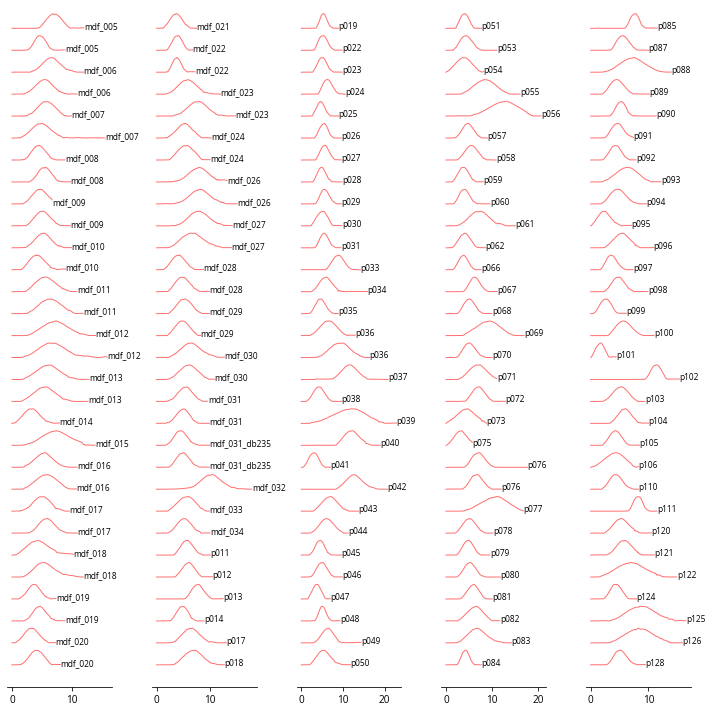

In [7]:
df_sts = df_trial[df_trial.trial_clean=='tug_cone']
# df_sts = df_sts.iloc[:50]
n = len(df_sts)

ncols = 5
plt.figure(figsize=(2*ncols,n/15))

for i in range(n):
    row = df_sts.iloc[i]
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rh = xyz[:,np.argmax(markers=='RHJC_study'),:]
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:]

    rhlh = rh-lh
    heading = np.arctan2(rhlh[:,0], rhlh[:,2]) * 180 / np.pi
    heading = np.unwrap(heading)
    avel = np.diff(heading, prepend=heading[0]) * fps

    mh = (rh + lh)/2
    dist = norm(mh - mh[0], axis=1)
    win = (dist.max() - dist) < 1
    
    turn_mean_avel = np.abs(np.mean(avel[win]*fps))

    dist -= dist.min()
    dist /= dist.max()

    t = np.arange(dist.size) / fps
    pid = row.pid

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, dist-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1)
    # plt.scatter(t[locs], h[locs]-i%(n/ncols)*1.5, s=6, c=cp[0])
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_tug.pdf')
plt.show()


  0%|          | 0/150 [00:00<?, ?it/s]

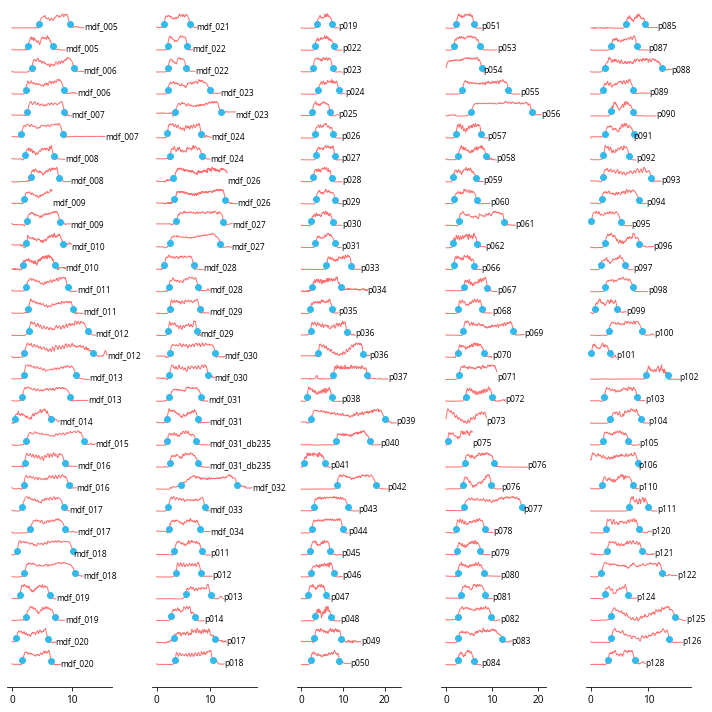

In [23]:
df_sts = df_trial[df_trial.trial_clean=='tug_cone']
# df_sts = df_sts.iloc[:50]
n = len(df_sts)

ncols = 5
plt.figure(figsize=(2*ncols,n/15))

for i in trange(n, leave=False):
    row = df_sts.iloc[i]
    pid = row.pid
    
    # if pid != 'p037':
    #     continue
    
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rh = xyz[:,np.argmax(markers=='RHJC_study'),:]
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:]
    mh = (rh + lh) / 2
    h = mh[:,1]
    h -= h.min()
    h /= h.max()
    
    if not np.any(h[:int(fps)] < 0.3):
        la = np.nan
    else:
        la = np.argmax(h > 0.3)
    if not np.any(h[-int(fps):] < 0.3):
        lb = np.nan
    else:
        lb = len(h) - np.argmax(h[-1::-1] > 0.7)
        lb = lb + np.argmax(h[lb:] < 0.3)

    tug_time = (lb - la)/fps
    
    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, h-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1)
    if not np.isnan(la):
        plt.scatter(t[la], h[la]-i%(n/ncols)*1.5, lw=1, c=cp[3])
    if not np.isnan(lb):
        plt.scatter(t[lb], h[lb]-i%(n/ncols)*1.5, lw=1, c=cp[3])
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_tug2.pdf')
plt.show()

